# Project 3 -Regression and Classification with the Ames Housing Data

## Part 3a
---
## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

## KNN as the classification model 

In [11]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

sns.set_style('white')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# h2 : updated house data
house = pd.read_csv('h2.csv')

del house['Unnamed: 0']
house.columns

Index([u'id', u'mssubclass', u'mszoning', u'lotfrontage', u'lotarea',
       u'street', u'lotshape', u'landcontour', u'utilities', u'lotconfig',
       u'landslope', u'neighborhood', u'condition1', u'condition2',
       u'bldgtype', u'housestyle', u'overallqual', u'overallcond',
       u'yearbuilt', u'yearremodadd', u'roofstyle', u'roofmatl',
       u'exterior1st', u'exterior2nd', u'exterqual', u'extercond',
       u'foundation', u'bsmtqual', u'bsmtcond', u'bsmtexposure',
       u'bsmtfintype1', u'bsmtfinsf1', u'bsmtfintype2', u'bsmtfinsf2',
       u'bsmtunfsf', u'totalbsmtsf', u'heating', u'heatingqc', u'centralair',
       u'electrical', u'1stflrsf', u'2ndflrsf', u'lowqualfinsf', u'grlivarea',
       u'bsmtfullbath', u'bsmthalfbath', u'fullbath', u'halfbath',
       u'bedroomabvgr', u'kitchenabvgr', u'kitchenqual', u'totrmsabvgrd',
       u'functional', u'fireplaces', u'fireplacequ', u'garagetype',
       u'garagefinish', u'garagecars', u'garagearea', u'garagequal',
       u'garageco

In [12]:
# encode the target class variable 'salecondition to be a binary 1 if Abnorml, 0 if not Abnorml
house['salecondition'] = house['salecondition'].map(lambda x: 1 if (x == 'Abnorml') else 0)
house['salecondition'].value_counts()

0    1354
1      96
Name: salecondition, dtype: int64

In [13]:
# choose a subset of house that have a potential impact on salecondition
col = ['age', 'remod_age', 'mssubclass', 'mszoning', 'lotarea', 'neighborhood', 'housestyle','salecondition']
h2 = house[col]  #h2 is the house subset
h2.head(4)

,age,remod_age,mssubclass,mszoning,lotarea,neighborhood,housestyle,salecondition
0,15,15,60,RL,8450,CollgCr,2Story,0
1,42,42,20,RL,9600,Veenker,1Story,0
2,17,16,60,RL,11250,CollgCr,2Story,0
3,103,48,70,RL,9550,Crawfor,2Story,1


In [14]:
# create df for the non numeric features
obj_df = h2.select_dtypes(include=['object']).copy()
obj_df.head(4)
c = list(obj_df)
print c


['mszoning', 'neighborhood', 'housestyle']


In [15]:
# get dummies for the obj
dummy = pd.get_dummies(obj_df, columns = ['mszoning', 'neighborhood', 'housestyle'],
                      prefix = ['mszoning', 'neighborhood', 'housestyle'])
print list(dummy.columns)

['mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'neighborhood_Blmngtn', 'neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_SWISU', 'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker', 'housestyle_1.5Fin', 'housestyle_1.5Unf', 'housestyle_1Story', 'housestyle_2.5Fin', 'housestyle_2.5Unf', 'housestyle_2Story', 'housestyle_SFoyer', 'housestyle_SLvl']


In [16]:
# delete column for dummy coding
dummy.drop(['mszoning_FV','neighborhood_Blmngtn','housestyle_1.5Fin'],axis=1,inplace=True)

In [17]:
h2 = pd.concat([h2, dummy], axis=1) # concat the dummy coding with the house subset
h2.drop(['mszoning','neighborhood','housestyle'],axis =1, inplace=True)
#print h2.head(4)
print list(h2.columns)

['age', 'remod_age', 'mssubclass', 'lotarea', 'salecondition', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_SWISU', 'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker', 'housestyle_1.5Unf', 'housestyle_1Story', 'housestyle_2.5Fin', 'housestyle_2.5Unf', 'housestyle_2Story', 'housestyle_SFoyer', 'housestyle_SLvl']


Text(0.5,1,u'Sale Condition Features')

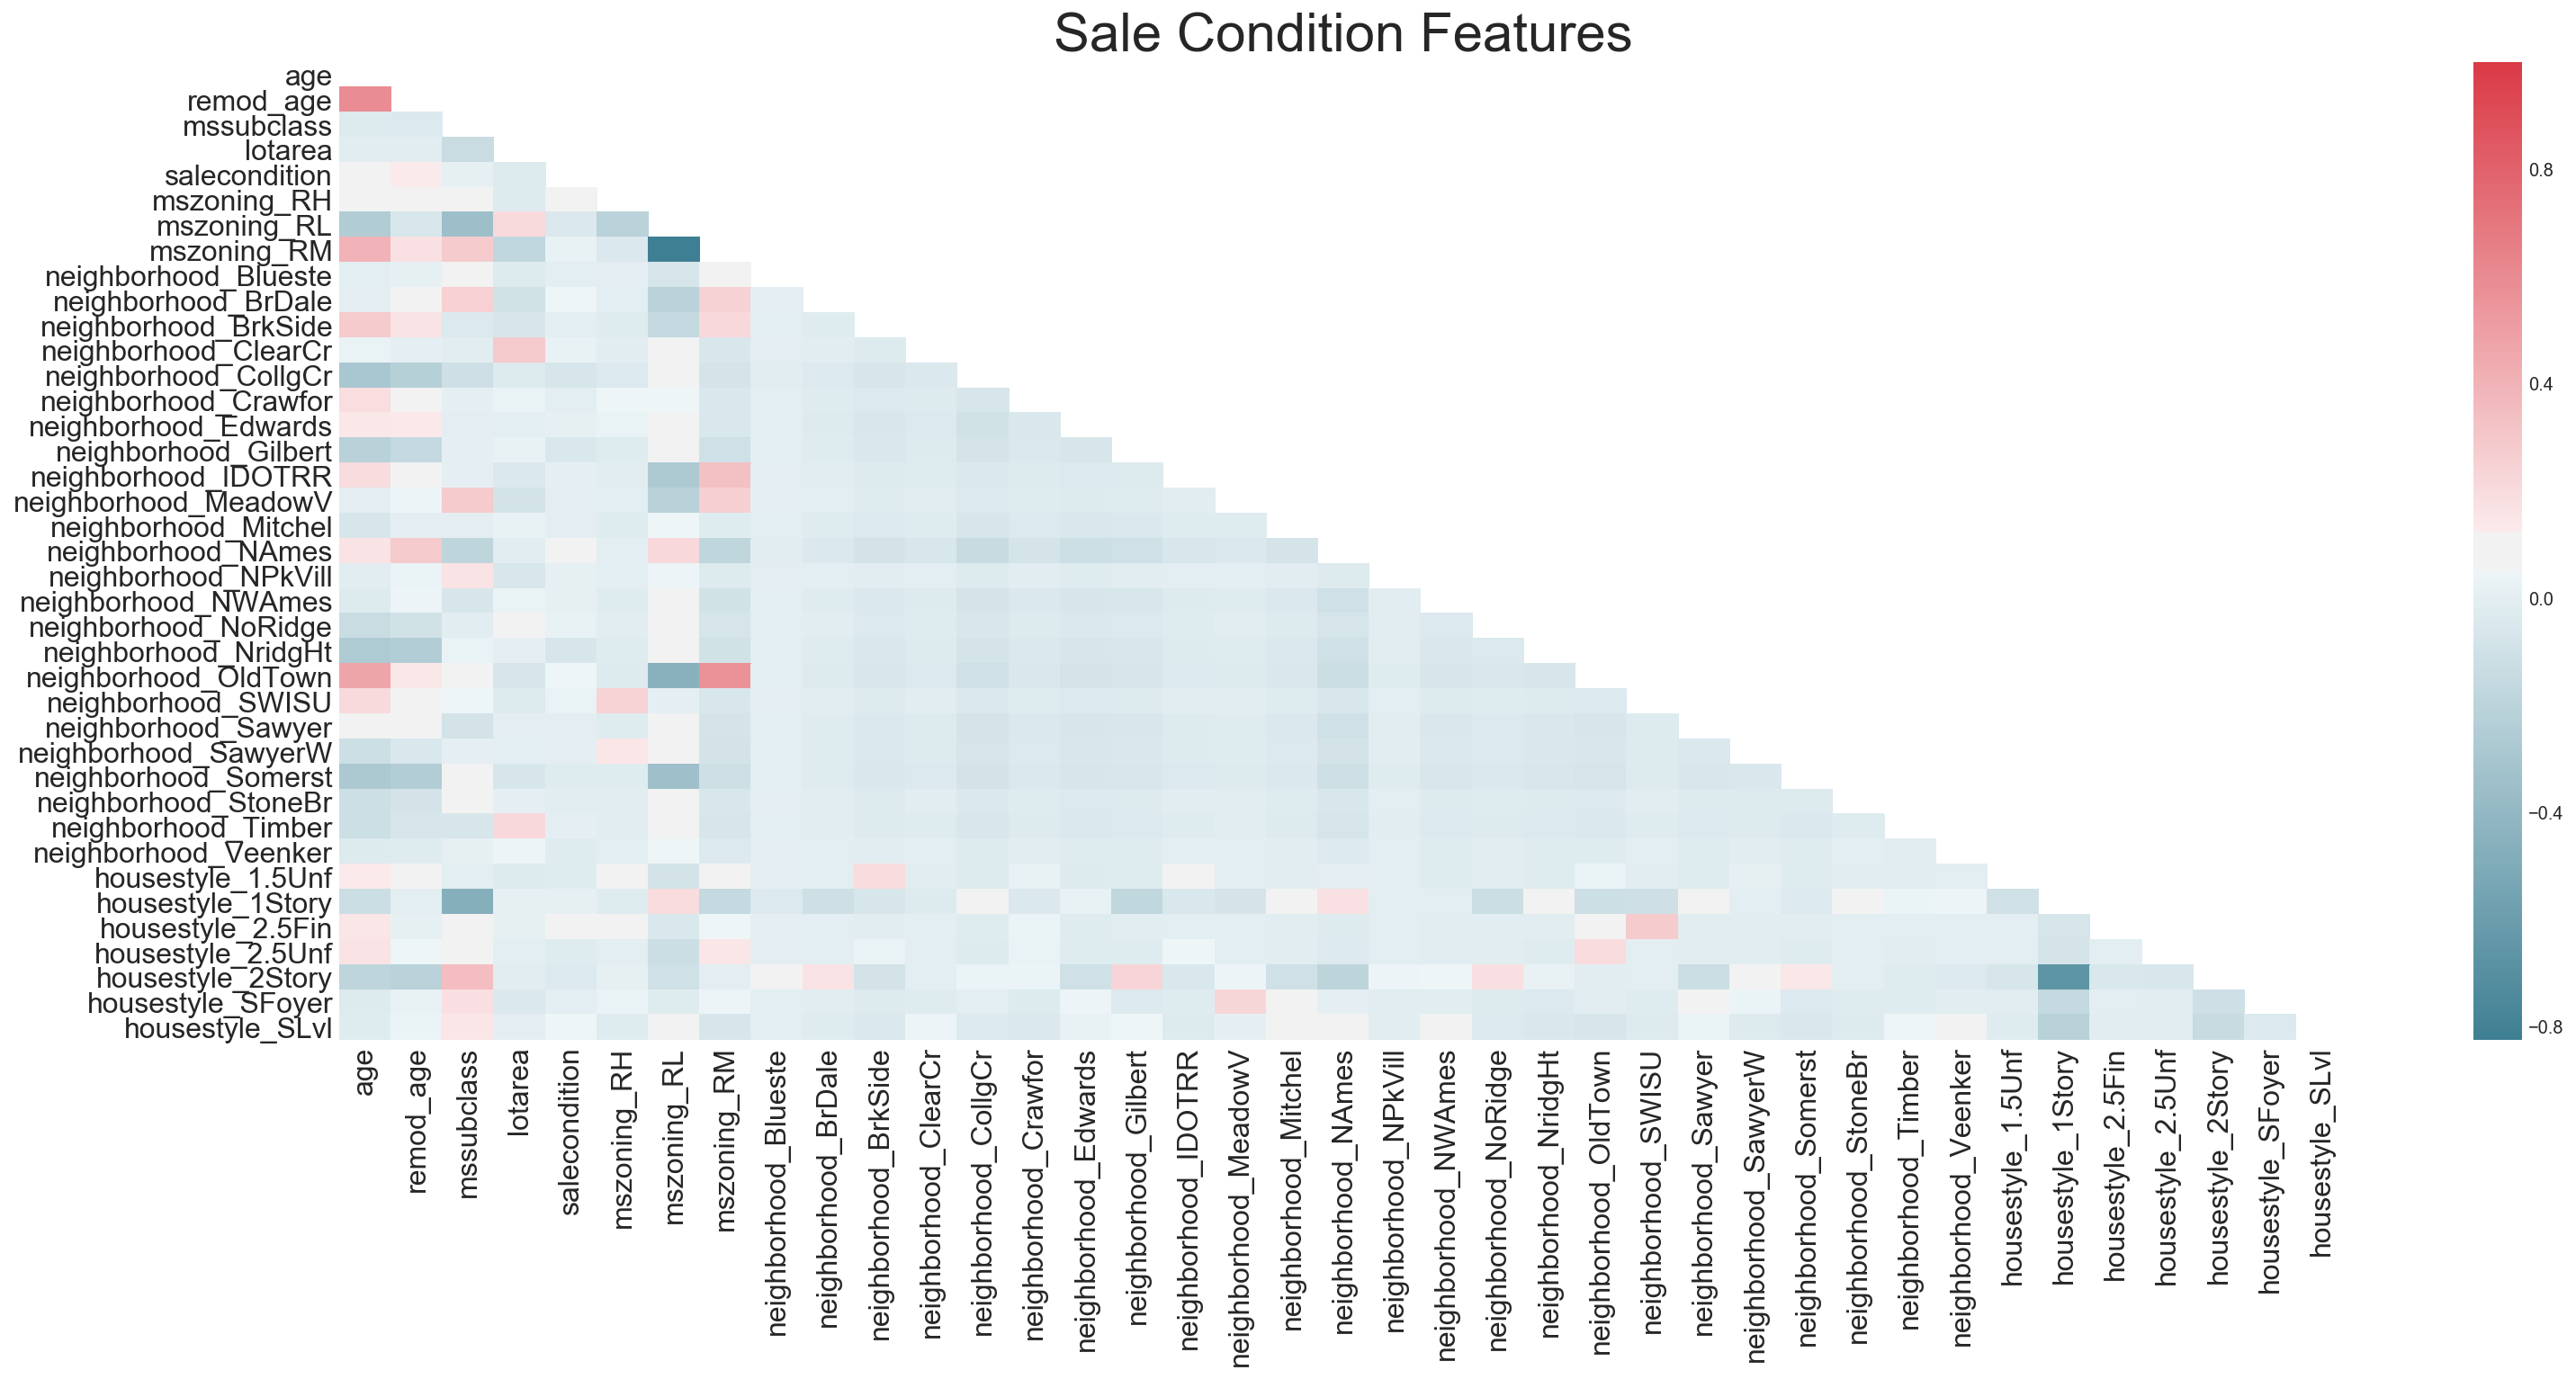

In [18]:
# examine correlation structure of the dataset

fig,ax=plt.subplots(figsize=(25,10))
cmap=sns.diverging_palette(220,10, as_cmap=True)

h2_corr=h2.corr()
mask=np.zeros_like(h2_corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plot_a = sns.heatmap(h2_corr, mask = mask, ax=ax, cmap=cmap)
plot_a.tick_params(labelsize = 16)
plot_a.set_title('Sale Condition Features', fontsize=30)

## Comments
Not seeing any correlation with the selected predictors

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


In [20]:
# create target vector and predictor matrix #1
y = h2['salecondition']
X = h2 [['age','remod_age','mssubclass', 'lotarea']]

# standardize the predictor matrix
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)


In [21]:
# create cross validation indices using StratifiedKFold
skf = StratifiedKFold(n_splits=5)
cv_indices = skf.split(Xs,y)
cv_indices =[[train,test] for train,test in cv_indices]


In [22]:
# baseline accuracy
baseline = 1 - np.mean(y)
print 'baseline:', baseline

baseline: 0.933793103448


In [23]:
# Function to crossvalidate accuracy of a knn model acros folds
def accuracy_crossvalidator(X, y, knn, cv_indices):
    # list to store the scores/accuracy of folds
    scores = []
    # iterate through the training and testing index folds in cv_indices
    for train_i, test_i in cv_indices:
        # get the current X train & test subsets of X
        X_train = X[train_i, :]
        X_test = X[test_i, :]
        # get the Y train & test subsets of Y
        Y_train = y[train_i]
        Y_test = y[test_i]
        # fit the knn model on the training data
        knn.fit(X_train, Y_train)
        # get the accuracy predicting the testing data
        acc = knn.score(X_test, Y_test)
        scores.append(acc)
        
        print('Fold accuracy:', acc)
        
    print('Mean CV accuracy:', np.mean(scores))
    return scores

In [24]:
# cross validate mean accuracy for a KNN with 5 neighbors
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
scores = accuracy_crossvalidator(Xs, y, knn5, cv_indices)

print 'baseline:', baseline
percent_gain = (((np.mean(scores))/baseline)-1)*100
print 'Percent Gain: ', percent_gain, '%'

('Fold accuracy:', 0.93127147766323026)
('Fold accuracy:', 0.93103448275862066)
('Fold accuracy:', 0.93103448275862066)
('Fold accuracy:', 0.92758620689655169)
('Fold accuracy:', 0.9307958477508651)
('Mean CV accuracy:', 0.93034449956557774)
baseline: 0.933793103448
Percent Gain:  -0.369311346375 %


In [25]:
# cross validate mean accuracy for a KNN with 2 neighbors
knn2 = KNeighborsClassifier(n_neighbors=2, weights='uniform')
scores = accuracy_crossvalidator(Xs, y, knn2, cv_indices)

print 'baseline:', baseline
percent_gain = (((np.mean(scores))/baseline)-1)*100
print 'Percent Gain: ', percent_gain, '%'

('Fold accuracy:', 0.92439862542955331)
('Fold accuracy:', 0.93103448275862066)
('Fold accuracy:', 0.93103448275862066)
('Fold accuracy:', 0.93103448275862066)
('Fold accuracy:', 0.92387543252595161)
('Mean CV accuracy:', 0.92827550124627334)
baseline: 0.933793103448
Percent Gain:  -0.590880590318 %


In [26]:
# cross validate mean accuracy for a KNN with 10 neighbors
knn10 = KNeighborsClassifier(n_neighbors=10, weights='uniform')
scores = accuracy_crossvalidator(Xs, y, knn10, cv_indices)

print 'baseline:', baseline
percent_gain = (((np.mean(scores))/baseline)-1)*100
print 'Percent Gain: ', percent_gain, '%'

('Fold accuracy:', 0.93127147766323026)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93425605536332179)
('Mean CV accuracy:', 0.93379516177772415)
baseline: 0.933793103448
Percent Gain:  0.000220426713438 %


In [27]:
# create target vector and predictor matrix #2
y = h2['salecondition']
X = h2 [['age', 'remod_age', 'mssubclass', 'lotarea', 'mszoning_RH', 'mszoning_RL',
         'mszoning_RM', 'neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr',
         'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards', 'neighborhood_Gilbert', 
         'neighborhood_IDOTRR', 'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes', 
         'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 
         'neighborhood_OldTown', 'neighborhood_SWISU', 'neighborhood_Sawyer', 'neighborhood_SawyerW', 
         'neighborhood_Somerst', 'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker', 
         'housestyle_1.5Unf', 'housestyle_1Story', 'housestyle_2.5Fin', 'housestyle_2.5Unf', 'housestyle_2Story', 
         'housestyle_SFoyer', 'housestyle_SLvl', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'neighborhood_Blueste', 
         'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_CollgCr', 
         'neighborhood_Crawfor', 'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR', 
         'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill', 
         'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_OldTown', 
         'neighborhood_SWISU', 'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst', 
         'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker', 'housestyle_1.5Unf', 
         'housestyle_1Story', 'housestyle_2.5Fin', 'housestyle_2.5Unf', 'housestyle_2Story', 'housestyle_SFoyer', 
         'housestyle_SLvl', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'neighborhood_Blueste', 'neighborhood_BrDale', 
         'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor', 
         'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV', 
         'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill', 'neighborhood_NWAmes', 
         'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_SWISU', 
         'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr', 
         'neighborhood_Timber', 'neighborhood_Veenker', 'housestyle_1.5Unf', 'housestyle_1Story', 'housestyle_2.5Fin', 
         'housestyle_2.5Unf', 'housestyle_2Story', 'housestyle_SFoyer', 'housestyle_SLvl']]

# standardize the predictor matrix
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [28]:
# create cross validation indices using StratifiedKFold
skf = StratifiedKFold(n_splits=5)
cv_indices = skf.split(Xs,y)
cv_indices =[[train,test] for train,test in cv_indices]


In [29]:
# cross validate mean accuracy for a KNN with 5 neighbors
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
scores = accuracy_crossvalidator(Xs, y, knn5, cv_indices)

print 'baseline:', baseline
percent_gain = (((np.mean(scores))/baseline)-1)*100
print 'Percent Gain: ', percent_gain, '%'

('Fold accuracy:', 0.92783505154639179)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.92758620689655169)
('Fold accuracy:', 0.93103448275862066)
('Fold accuracy:', 0.92387543252595161)
('Mean CV accuracy:', 0.92896278646964103)
baseline: 0.933793103448
Percent Gain:  -0.517279144684 %


In [30]:
# cross validate mean accuracy for a KNN with 2 neighbors
knn2 = KNeighborsClassifier(n_neighbors=2, weights='uniform')
scores = accuracy_crossvalidator(Xs, y, knn2, cv_indices)

print 'baseline:', baseline
percent_gain = (((np.mean(scores))/baseline)-1)*100
print 'Percent Gain: ', percent_gain, '%'

('Fold accuracy:', 0.92096219931271472)
('Fold accuracy:', 0.93103448275862066)
('Fold accuracy:', 0.92758620689655169)
('Fold accuracy:', 0.93103448275862066)
('Fold accuracy:', 0.91349480968858132)
('Mean CV accuracy:', 0.92482243628301786)
baseline: 0.933793103448
Percent Gain:  -0.960669674271 %


In [31]:
# cross validate mean accuracy for a KNN with 10 neighbors
knn10 = KNeighborsClassifier(n_neighbors=10, weights='uniform')
scores = accuracy_crossvalidator(Xs, y, knn10, cv_indices)

print 'baseline:', baseline
percent_gain = (((np.mean(scores))/baseline)-1)*100
print 'Percent Gain: ', percent_gain, '%'

('Fold accuracy:', 0.93127147766323026)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93425605536332179)
('Mean CV accuracy:', 0.93379516177772415)
baseline: 0.933793103448
Percent Gain:  0.000220426713438 %


In [32]:
# hypothesis: neighborhood is factor
y = h2['salecondition']
X = h2 [['neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr',
         'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards', 'neighborhood_Gilbert', 
         'neighborhood_IDOTRR', 'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes', 
         'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 
         'neighborhood_OldTown', 'neighborhood_SWISU', 'neighborhood_Sawyer', 'neighborhood_SawyerW', 
         'neighborhood_Somerst', 'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker', 
         'neighborhood_Blueste', 
         'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_CollgCr', 
         'neighborhood_Crawfor', 'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR', 
         'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill', 
         'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_OldTown', 
         'neighborhood_SWISU', 'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst', 
         'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker', 'neighborhood_Blueste', 'neighborhood_BrDale', 
         'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor', 
         'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV', 
         'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill', 'neighborhood_NWAmes', 
         'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_SWISU', 
         'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr', 
         'neighborhood_Timber', 'neighborhood_Veenker']]

# standardize the predictor matrix
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)


In [33]:
# create cross validation indices using StratifiedKFold
skf = StratifiedKFold(n_splits=5)
cv_indices = skf.split(Xs,y)
cv_indices =[[train,test] for train,test in cv_indices]

In [34]:
# cross validate mean accuracy for a KNN with 5 neighbors
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
scores = accuracy_crossvalidator(Xs, y, knn5, cv_indices)

print 'baseline:', baseline
percent_gain = (((np.mean(scores))/baseline)-1)*100
print 'Percent Gain: ', percent_gain, '%'

('Fold accuracy:', 0.93127147766323026)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93425605536332179)
('Mean CV accuracy:', 0.93379516177772415)
baseline: 0.933793103448
Percent Gain:  0.000220426713438 %


In [35]:
# cross validate mean accuracy for a KNN with 2 neighbors
knn2 = KNeighborsClassifier(n_neighbors=2, weights='uniform')
scores = accuracy_crossvalidator(Xs, y, knn2, cv_indices)

print 'baseline:', baseline
percent_gain = (((np.mean(scores))/baseline)-1)*100
print 'Percent Gain: ', percent_gain, '%'

('Fold accuracy:', 0.93127147766323026)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93425605536332179)
('Mean CV accuracy:', 0.93379516177772415)
baseline: 0.933793103448
Percent Gain:  0.000220426713438 %


In [36]:
# cross validate mean accuracy for a KNN with 10 neighbors
knn10 = KNeighborsClassifier(n_neighbors=10, weights='uniform')
scores = accuracy_crossvalidator(Xs, y, knn10, cv_indices)

print 'baseline:', baseline
percent_gain = (((np.mean(scores))/baseline)-1)*100
print 'Percent Gain: ', percent_gain, '%'

('Fold accuracy:', 0.93127147766323026)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93448275862068964)
('Fold accuracy:', 0.93425605536332179)
('Mean CV accuracy:', 0.93379516177772415)
baseline: 0.933793103448
Percent Gain:  0.000220426713438 %


## Comments
It appears that KNN model with the features used, does not provide any additional insight as is